In [1]:
!pip install seaborn
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm



In [2]:
articles = pd.read_csv("./articles.csv")
customers = pd.read_csv("./customers.csv")
transactions = pd.read_csv("./transactions_train.csv")

In [3]:
articles['prod_name'].unique()

array(['Strap top', 'Strap top (1)', 'OP T-shirt (Idro)', ...,
       'Cartwheel dress', 'CLAIRE HAIR CLAW', 'Lounge dress'],
      dtype=object)

In [4]:
articles.sample()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
32559,635425001,635425,Blake,258,Blouse,Garment Upper body,1010016,Solid,73,Dark Blue,...,Blouse,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1010,Blouses,V-neck blouse in woven fabric with short ragla...


In [5]:
transactions.sample()

,t_dat,customer_id,article_id,price,sales_channel_id
27754786,2020-06-22,4ee60d1d5959f338468a6b8a07748e02ce1d252446473c...,872454002,0.019051,1


In [7]:
!pip install pyarrow
!pip install fastparquet
train = transactions.copy()

train['article_id'] = train.article_id.astype('int32')
train.t_dat = pd.to_datetime(train.t_dat)
train = train[['t_dat','customer_id','article_id']]
train.to_parquet('train.pqt',index=False)
print( train.shape )
train.sample()

   ---------------------------------------- 0.0/24.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.6 MB 1.6 MB/s eta 0:00:16
   - -------------------------------------- 1.1/24.6 MB 14.4 MB/s eta 0:00:02
   ----- ---------------------------------- 3.6/24.6 MB 28.8 MB/s eta 0:00:01
   ---------- ----------------------------- 6.6/24.6 MB 38.0 MB/s eta 0:00:01
   --------------- ------------------------ 9.3/24.6 MB 42.5 MB/s eta 0:00:01
   ------------------- -------------------- 12.3/24.6 MB 59.5 MB/s eta 0:00:01
   ------------------------ --------------- 15.0/24.6 MB 59.5 MB/s eta 0:00:01
   ---------------------------- ----------- 17.6/24.6 MB 59.5 MB/s eta 0:00:01
   --------------------------------- ------ 20.6/24.6 MB 59.5 MB/s eta 0:00:01
   ------------------------------------- -- 23.4/24.6 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------  24.6/24.6 MB 59.5 MB/s eta 0:00:01
   ---------------------------------------- 24.6/24.6 MB 46.7 MB/s 

,t_dat,customer_id,article_id
23201571,2020-03-08,91bfa35161d95210224958e0cdf496a15e07a6c9062a82...,806731001


### 각 고객이 최근 일주일 동안 구매한 제품


In [8]:
tmp = train.groupby('customer_id').t_dat.max().reset_index()
tmp.columns = ['customer_id','max_dat']
train = train.merge(tmp,on=['customer_id'],how='left')
train['diff_dat'] = (train.max_dat - train.t_dat).dt.days
train = train.loc[train['diff_dat']<=6]
print('Train shape:',train.shape)

Train shape: (5181535, 5)


In [9]:
train = pd.merge(train, articles[['article_id', 'product_type_name']], how='left', on = 'article_id')
train = train[train['product_type_name'] == 'Shirt']

### 고객이 과거에 가장 자주 구매한 제품 추천

In [10]:
tmp = train.groupby(['customer_id','article_id'])['t_dat'].agg('count').reset_index()
tmp.columns = ['customer_id','article_id','ct']
train = train.merge(tmp,on=['customer_id','article_id'],how='left')
train = train.sort_values(['ct','t_dat'],ascending=False)
train = train.drop_duplicates(['customer_id','article_id'])
train = train.sort_values(['ct','t_dat'],ascending=False)
train.head()

,t_dat,customer_id,article_id,max_dat,diff_dat,product_type_name,ct
34615,2019-07-16,18d346ffea696df26aa1d53ee19afbf250a92288fc1282...,719348003,2019-07-16,0,Shirt,100
124593,2020-09-13,61da44a2758206d5701771f4315637b40c8321b5111916...,850917001,2020-09-13,0,Shirt,58
16162,2019-01-02,41b6d86f47cc7412b3e714d750d5917f19a3617505d3b4...,507909003,2019-01-02,0,Shirt,49
8958,2018-11-15,dda4bd482b3fd1831c8c3cec9097c0c2e0a77dc7954f3f...,607834007,2018-11-15,0,Shirt,48
16211,2019-01-02,41b6d86f47cc7412b3e714d750d5917f19a3617505d3b4...,501616009,2019-01-02,0,Shirt,40


In [11]:
train.shape

(120671, 7)

In [12]:
!pip install apyori

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5974 sha256=611256e4537001f4fbcc1172e06046197d8e39ede7d9f02b88b0cd24e55b2d18
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\32\2a\54\10c595515f385f3726642b10c60bf788029e8f3a1323e3913a
Successfully built apyori


In [13]:
from apyori import apriori

In [14]:
# 각 고객이 구매한 제품 수 계산
article_counts = train.groupby('customer_id')['article_id'].count()

# 10개 이상의 제품을 구매한 고객 제외
customers_to_keep = article_counts[article_counts < 10].index

# 원본 데이터 프레임 필터링
filtered_train = train[train['customer_id'].isin(customers_to_keep)]

<Axes: xlabel='0', ylabel='Count'>

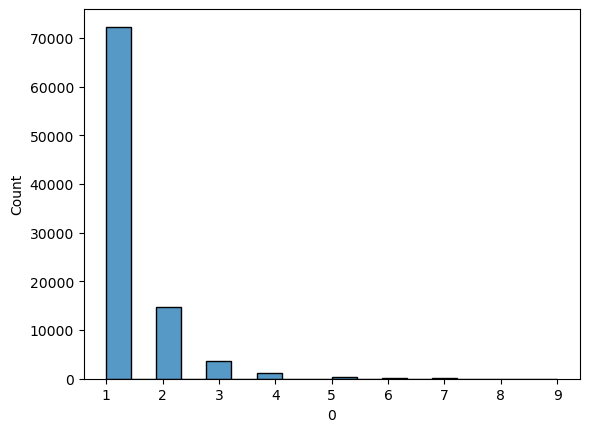

In [15]:
transaction_counts = filtered_train.groupby('customer_id').size().reset_index()
sns.histplot(data=transaction_counts, x=0)

In [16]:
transactions_list = filtered_train.groupby('customer_id')['article_id'].apply(
    lambda x: list(set(x))[:2] if len(set(x)) >= 2 else None
).dropna().tolist()

In [17]:
filtered_train['article_id'].nunique()

2886

In [18]:
len(transactions_list)

20013

In [19]:
rules = apriori(transactions = transactions_list, min_support=0.001, min_confidence=0.001, min_lift=1.001, min_length=2, max_length=2)


In [20]:
results = list(rules)
len(results)

41

In [21]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Left Hand Side', 'Right Hand Side', 'Support', 'Confidence', 'Lift'])

In [22]:
# 'Left Hand Side'을 기준으로 그룹화하고 최대 'Lift' 값 가진 index 찾기
max_lift_indices = resultsinDataFrame.groupby('Left Hand Side')['Lift'].idxmax()

# 'Lift' 값이 가장 높은 행만 유지
filtered_df = resultsinDataFrame.loc[max_lift_indices]

In [23]:
filtered_df.shape

(20, 5)

In [24]:
filtered_df.nlargest(n = 10, columns = 'Lift')

,Left Hand Side,Right Hand Side,Support,Confidence,Lift
40,928206001,928351001,0.001149,0.370968,224.975073
37,855748001,855748002,0.001349,0.450000,132.438971
32,789772001,789772003,0.001249,0.138122,35.438802
39,871710001,871710010,0.001699,0.184783,35.219565
7,507909024,507909026,0.001049,0.185841,34.759160
0,395127001,395127011,0.001249,0.162338,29.535124
1,501616007,501616009,0.001299,0.211382,26.439939
8,507910001,507910004,0.001249,0.109170,21.848253
38,859139001,859139002,0.001999,0.253165,21.559925
31,781758001,781758004,0.001049,0.082677,20.944533


In [27]:
BASE = './images/'

name1 = BASE+'0'+str(855748001)[:2]+'/0'+str(855748001)+'.jpg'
name2 = BASE+'0'+str(855748002)[:2]+'/0'+str(855748002)+'.jpg'

   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.1 MB 1.4 MB/s eta 0:00:28
   - -------------------------------------- 1.8/38.1 MB 22.8 MB/s eta 0:00:02
   ---- ----------------------------------- 4.7/38.1 MB 37.4 MB/s eta 0:00:01
   -------- ------------------------------- 7.6/38.1 MB 44.2 MB/s eta 0:00:01
   ----------- ---------------------------- 10.6/38.1 MB 59.8 MB/s eta 0:00:01
   ------------- -------------------------- 12.6/38.1 MB 59.5 MB/s eta 0:00:01
   ------------- -------------------------- 12.6/38.1 MB 59.5 MB/s eta 0:00:01
   ------------- -------------------------- 12.7/38.1 MB 36.4 MB/s eta 0:00:01
   ---------------- ----------------------- 15.6/38.1 MB 36.4 MB/s eta 0:00:01
   ------------------- -------------------- 18.5/38.1 MB 36.4 MB/s eta 0:00:01
   ---------------------- ----------------- 21.4/38.1 MB 36.3 MB/s eta 0:00:01
   ------------------------- -------------- 24.2/38.1 MB 59.5 MB/s

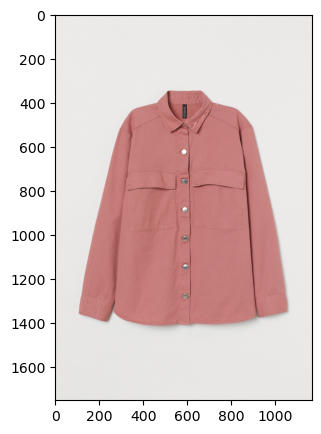

In [29]:
!pip install opencv-python
import cv2, matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
img1 = cv2.imread(name1)[:,:,::-1]
plt.imshow(img1)
plt.show()

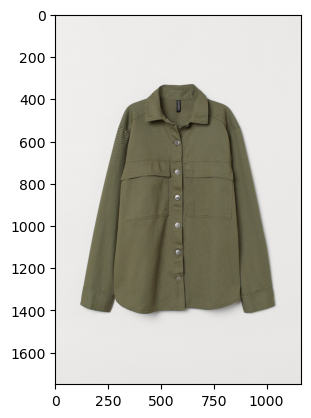

In [30]:
img2 = cv2.imread(name2)[:,:,::-1]
plt.imshow(img2)
plt.show()